### Tutorial 11: Fun with MCMC continued!

In the previous tutorial we started scratching the surface of sampling the parameter space with MCMC. In this tutorial we will focus on convergence (or lack thereof) and on offloading computations to an external computing cluster.

Let's start with the usual imports.

In [1]:
import phoebe
import numpy as np
import matplotlib.pyplot as plt

In addition, we will need two more helper functions, erfinv to compute inverse error function, and norm to compute gaussian percentiles:

In [2]:
from scipy.special import erfinv
from scipy.stats import norm

Load the data from the previous run:

In [3]:
b = phoebe.load('./data/synthetic/after_initial_sampling.bundle')

/usr/local/lib/python3.9/dist-packages/phoebe/parameters/parameters.py:10312: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self._value = np.array(value)


When running the sampler, we focused on the depiction of the results; let us now take a more systematic look at the sampler output:

In [4]:
print(b['round_1'])

ParameterSet: 21 parameters
R  wrap_central_values@round_1...: {'ByxjzcQpLyAKDbHYqUyvbnvvOCjoDX': 90.3431416538605}
R  fitted_uniqueids@dyn_rv@rou...: ['JBtLJKojBQcDccDuBHXsRkXRyBLDGM' 'gxSYROyAvbaqfuFRcxkjKrnFZDAyuV'
 'kSzhytUdmWSDmYdPzsVIMSPuxVIFla' 'qEdMVEJqyIlNvRlBrKtxNBKNayHwrG'
 'ByxjzcQpLyAKDbHYqUyvbnvvOCjoDX']
R  fitted_twigs@dyn_rv@round_1...: ['asini@binary@orbit@component' 'q@binary@orbit@component' 'vgamma@system'
 'ecc@binary@orbit@component' 'per0@binary@orbit@component']
R  fitted_units@dyn_rv@round_1...: ['solRad' '' 'km / s' '' 'deg']
   adopt_parameters@dyn_rv@rou...: ['asini@binary@orbit@component', 'q@binary@orbit@component', 'vgamma@system', 'ecc@binary@orbit@component', 'per0@binary@orbit@component']
   adopt_distributions@dyn_rv@...: True
   distributions_convert@round...: mvsamples
   adopt_values@dyn_rv@round_1...: True
R         niters@round_1@solution: 100
R       nwalkers@round_1@solution: 16
R        samples@round_1@solution: [[[8.00450682e+00 6.46755112e-0

Lots to digest here. So let's get started!

`wrap_central_values` and `fitted_uniqueids`: safe to ignore; these are used internally and will likely be abstracted away in a future release. They're used to do faster lookups by the hash and looping over them is more efficient than filtering;

`comments`: human-readable comments about the solution, to be used for reference;

`fitted_twigs`: parameter twigs that were sampled;

`fitted_units`: the units of parameters that were sampled;

`adopt_parameters`: list of sampled parameters for which the solution should be adopted; don't choose a subset unless you have a very good reason;

`adopt_distributions`: should distributions be stored;

`distributions_convert`: should a simplified representation of the distributions be stored;

`adopt_values`: should face values be stored;

`distributions_convert`: should space-friendly descriptors be used instead of full discrete distributions;

`niters`: number of iterations used to reach the solution;

`nwalkers`: number of walkers used to reach the solution;

`samples`: MCMC samples of the shape (niters, nwalkers, npars);

`failed_samples`: MCMC samples that resulted in lnp=-inf; the return value is a dictionary where keys are failure messages and values are arrays of parameter combinations that caused the failure;

`lnprobabilities`: sampled log-probabilities of the shape (niters, nwalkers);

`acceptance_fractions`: used for convergence evaluation, provided per walker;

`autocorr_times`: autocorrelation times, used for convergence evaluation, provided per parameter;

`burnin`, `thin`, `lnprob_cutoff`: sample modifiers discussed in the previous tutorial;

`nlags`: number of autocorrelation lags to use when calculating autocorrelation;

`progress`: progress meter; useful when farming out to a cluster and checking an intermediate result.

Remember that you can always print a certain parameter to get more verbose help on its purpose:

In [5]:
print(b['distributions_convert'])

Parameter: distributions_convert@round_1@solution
                       Qualifier: distributions_convert
                     Description: type of distribution to use when calling adopt_solution, get_distribution_collection, or plot. mvsamples: chains are stored directly and used for sampling with a KDE generated on-the-fly to compute probabilities.  mvhistogram: chains are binned according to distributions_bins and stored as an n-dimensional histogram.  mvgaussian: a multivariate gaussian is fitted to the samples, use only if distribution is sufficiently represented by gaussians.  samples: a univariate representation of mvsamples.  histogram: a univariate representation of mvhistogram.  gaussian: a univariate representation of mvgaussian.
                           Value: mvsamples
                         Choices: mvsamples, mvhistogram, mvgaussian, samples, histogram, gaussian
                  Constrained by: 
                      Constrains: None
                      Related to

As we ran the sampler, some combinations of parameters resulted in 0 likelihood. We refer to those as failed samples and, as seen above, they are stored as part of the solution. We can easily plot those in a corner plot:

(None, <Figure size 849.6x849.6 with 25 Axes>)

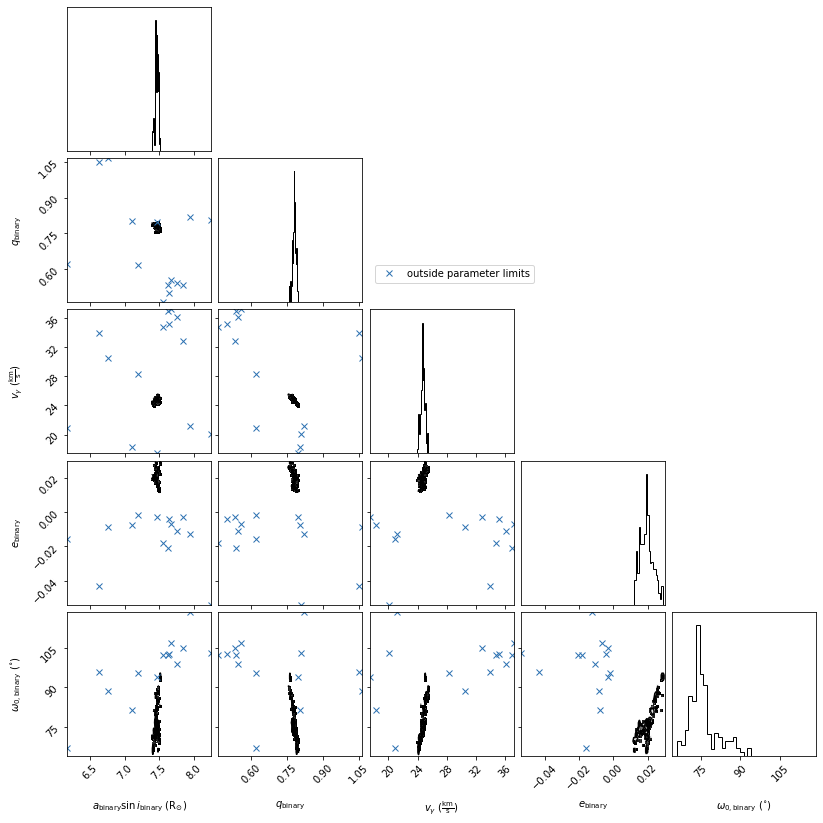

In [6]:
b.plot(solution='round_1', style='failed', burnin=50, show=True)

This is clearly a severely undersampled parameter space, but it's already evident where the failed samples lie; in this particular case, all values that fail are outside of parameter limits.

We can now compute the average RV curve from, say, 25 samples drawn from the round 1 solution:

In [7]:
b.run_compute(compute='dyn_rv', sample_from='round_1', sample_num=25, model='from_posteriors')

100%|██████████| 25/25 [00:13<00:00,  1.85it/s]


<ParameterSet: 10 parameters | components: primary, secondary>

Once computed, let's plot all 25 samples in the phase plot:

/usr/local/lib/python3.9/dist-packages/phoebe/dependencies/autofig/call.py:1305: UserWarning: You passed a edgecolor/edgecolors ('none') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  artist = ax.scatter(*datapoint,


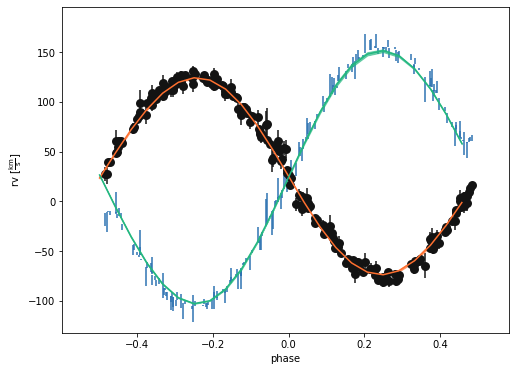

(<autofig.figure.Figure | 1 axes | 4 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [8]:
b.plot(model='from_posteriors', x='phase', show=True)

Happy with this? We can inspect the solution by running the `adopt_solution()` method with the `trial_run` argument set to `True`:

In [9]:
print(b.adopt_solution(solution='round_1', trial_run=True))

ParameterSet: 10 parameters
       asini@dists03@distribution: <distl.mvsamplesslice dimension=0 samples=[[7.61761658e+00 7.44862588e-01 2.61038394e+01 2.56792049e-02
  1.02259455e+02]
 [7.52489228e+00 7.62745325e-01 2.61784415e+01 2.76774059e-02
  9.96596618e+01]
 [7.54474265e+00 7.51856504e-01 2.36106333e+01 2.67391365e-02
  9.64290504e+01]
 ...
 [7.51981846e+00 7.87285389e-01 2.45521669e+01 1.16660703e-02
  7.03045030e+01]
 [7.49865742e+00 7.80657988e-01 2.45254353e+01 1.27257368e-02
  7.04743770e+01]
 [7.47401865e+00 7.78848658e-01 2.47415522e+01 1.65237281e-02
  7.40922291e+01]] weights=None bw_method=None unit=solRad label=asini@binary)>
           q@dists03@distribution: <distl.mvsamplesslice dimension=1 samples=[[7.61761658e+00 7.44862588e-01 2.61038394e+01 2.56792049e-02
  1.02259455e+02]
 [7.52489228e+00 7.62745325e-01 2.61784415e+01 2.76774059e-02
  9.96596618e+01]
 [7.54474265e+00 7.51856504e-01 2.36106333e+01 2.67391365e-02
  9.64290504e+01]
 ...
 [7.51981846e+00 7.8728538

Before we adopt, though, let's have another (quick) coffee break -- let's continue sampling for another 25 iterations. The solvers and solutions that we have so far are:

In [10]:
b.solvers

['rvperiod',
 'lcperiod_bls',
 'lcperiod_ls',
 'rvgeom',
 'ebai_est',
 'lcgeom',
 'nm_solver',
 'mcmc']

In [11]:
b.solutions

['rvperiod_solution',
 'rvperiod_solution_2',
 'lcperiod_bls_solution',
 'lcperiod_ls_solution',
 'rvgeom_solution',
 'ebai_solution',
 'lcgeom_solution',
 'nm_solution',
 'round_1']

Remember the `continue_from` parameter of the solver? That's what we want to set!

In [12]:
print(b['continue_from@mcmc'])

Parameter: continue_from@mcmc@solver
                       Qualifier: continue_from
                     Description: continue the MCMC run from an existing emcee solution.  Chains will be appended to existing chains (so it is safe to overwrite the existing solution).  If None, will start a new run using init_from.
                           Value: None
                         Choices: None, round_1
                  Constrained by: 
                      Constrains: None
                      Related to: None



In [13]:
b['continue_from@mcmc'] = 'round_1'

The `niters` parameter will now correspond to the number of additional iterations; note that we need to specify here that we are setting `niters@solver` and not `niters@solution` (which is read-only anyway).

In [14]:
b['niters@mcmc@solver'] = 25

In [15]:
b.run_solver('mcmc', solution='round_2')

100%|██████████| 25/25 [03:03<00:00,  7.47s/it]WARNING:root:The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 2;
tau: [11.78677477 14.71681843 12.75967169 15.97985163 15.64156844]
100%|██████████| 25/25 [03:03<00:00,  7.32s/it]


<ParameterSet: 20 parameters | qualifiers: distributions_convert, lnprob_cutoff, thin, acceptance_fractions, nwalkers, failed_samples, niters, burnin, adopt_values, adopt_distributions, comments, adopt_parameters, fitted_twigs, wrap_central_values, lnprobabilities, fitted_units, nlags, samples, autocorr_times, progress>

We can now compare the results from the first sample (`round_1`) and from the second sample (`round_2`):

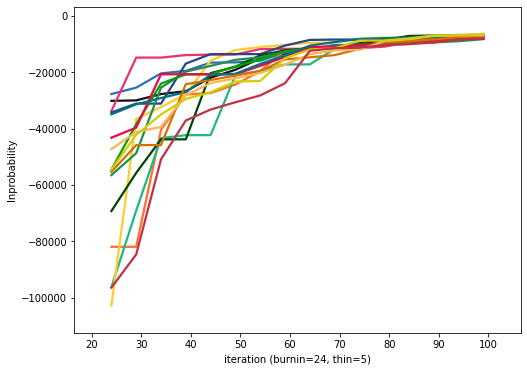

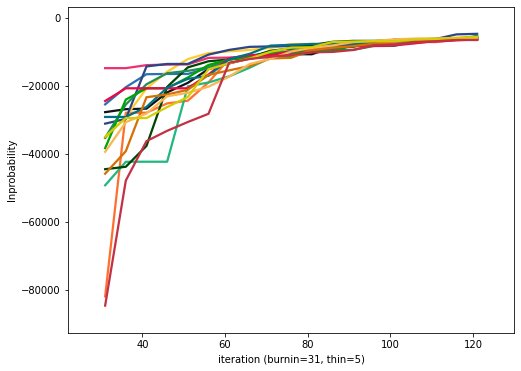

(<autofig.figure.Figure | 1 axes | 16 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [16]:
b.plot(solution='round_1', style='lnprobability', show=True)
b.plot(solution='round_2', style='lnprobability', show=True)

Several things worthy of mention here. First, note the span of the x-axis. It starts by the determined `burnin` value for each sample run (24 for round 1 and 31 for round 2), and it goes to the `niters` value (100 for round 1 and 125 for round 2).

How does phoebe estimate the value of `burnin`? It looks at the autocorrelation times, which emcee returns for each parameter. It then pick the longest autocorrelation time and multiplies it by the `burnin_factor`. Thus:

In [17]:
print('burnin iterations for round 1: %d' % 
      (int(max(b['value@autocorr_times@round_1'])*b['value@burnin_factor@mcmc'])))
print('burnin iterations for round 2: %d' % 
      (int(max(b['value@autocorr_times@round_2'])*b['value@burnin_factor@mcmc'])))

burnin iterations for round 1: 24
burnin iterations for round 2: 31


The value of log-probability, as well as the fact that it's still rising, hints that the solution has not yet converged. So we need to run a longer chain. As running 25 iterations locally took 3 minutes, we will offload this computation to a computer cluster. We covered the server setup in [Tutorial 9](Tutorial_09_server.ipynb), so we won't recreate it here; instead, we will rely on the already saved server (named `terra`) and add the server to the bundle. As a reminder, we keep the aggregated steps to initialize a server commented out here for simpler reference.

In [18]:
# from phoebe.dependencies import crimpl
# s = crimpl.RemoteSlurmServer(host='terra', directory='~/workshop/crimpl')
# s.install_conda()
# s.save('terra', overwrite=True)

Let's add a server to the bundle; as always, parameters can either be added as arguments, or by editing the instantiated parameter set later on.

In [19]:
b.add_server('remoteslurm',
             crimpl_name='terra',
             conda_env='workshop',
             nprocs=96,
             server='terra',
             walltime=(12,'h'))

<ParameterSet: 11 parameters | qualifiers: walltime, use_conda, crimpl_name, use_mpi, conda_env, isolate_env, mail_type, nprocs, slurm_job_name, install_deps, mail_user>

In [20]:
print(b['terra@server'])

ParameterSet: 10 parameters
         crimpl_name@terra@server: terra
           use_conda@terra@server: True
           conda_env@terra@server: workshop
         isolate_env@terra@server: False
              nprocs@terra@server: 96
             use_mpi@terra@server: True
        install_deps@terra@server: True
      slurm_job_name@terra@server: 
            walltime@terra@server: 12.0 h
           mail_user@terra@server: 


Once the server is initialized, we assign the `use_server` parameter to it:

In [21]:
print(f"original server: {b['value@use_server@dyn_rv']}")
b['use_server@dyn_rv'] = 'terra'
print(f"updated server: {b['value@use_server@dyn_rv']}")

original server: none
updated server: terra


Given that we are offloading this computation to the HPC, let's increase the number of walkers from the current  16 to, say, 48, so that the sampler can traverse the parameter space more efficiently. The parameter `nwalkers` is in the solver parameter set:

In [22]:
print(b['mcmc@solver'])

ParameterSet: 11 parameters
             comments@mcmc@solver: 
           use_server@mcmc@solver: compute
              compute@mcmc@solver: dyn_rv
        continue_from@mcmc@solver: round_1
   init_from_requires@mcmc@solver: ['limits', 'priors']
               priors@mcmc@solver: []
               niters@mcmc@solver: 25
        burnin_factor@mcmc@solver: 2.0
          thin_factor@mcmc@solver: 0.5
         nlags_factor@mcmc@solver: 3.0
   progress_every_niters@mcmc@...: 0


Wait, it disappeared? No, it hasn't disappeared, it is hidden because we have `continue_from` set to the previous run, from which any new run will inherit all sampling parameters. Thus, we first need to set `continue_from` to none:

In [32]:
b['continue_from@mcmc@solver'] = 'None'
print(b['mcmc@solver'])

ParameterSet: 15 parameters
             comments@mcmc@solver: 
           use_server@mcmc@solver: compute
              compute@mcmc@solver: dyn_rv
        continue_from@mcmc@solver: None
            init_from@mcmc@solver: ['ndg']
    init_from_combine@mcmc@solver: first
   init_from_requires@mcmc@solver: ['limits', 'priors']
               priors@mcmc@solver: []
             nwalkers@mcmc@solver: 48
               niters@mcmc@solver: 25
        burnin_factor@mcmc@solver: 2.0
          thin_factor@mcmc@solver: 0.5
         nlags_factor@mcmc@solver: 3.0
   progress_every_niters@mcmc@...: 0
        expose_failed@mcmc@solver: True


There it is! Now we can change it!

In [24]:
b['nwalkers@mcmc@solver'] = 48

But now how do we continue from the previous run? We obviously cannot literally continue because we have changed the sampler properties; instead, we need to *resample* from the last run. We do that by using the `init_from` parameter. In order to have something to initialize from, we first need to adopt parameters from the last run:

In [25]:
b.adopt_solution(solution='round_2',
                 adopt_values=False,
                 adopt_distributions=True,
                 distributions_convert='mvsamples',
                 distribution='ndg_2')

<ParameterSet: 5 parameters | qualifiers: q, vgamma, per0, ecc, asini>

Now we have a new distribution:

In [28]:
b.distributions

['dist01', 'ndg', 'ndg_2']

We can use this new distribution to set the `init_from` parameter. The sampler will then use `ndg_2` to get a new sample for all initial values and continue from there.

In [33]:
b['init_from@mcmc@solver'] = 'ndg_2'

We're now ready to run the sampler! If you feel like taking a lunch break, you might want to uncomment the line below and run the sampler; in the interest of time for this tutorial, though, we will load the precomputed results instead.

In [ ]:
b.run_solver('mcmc', solution='round_3')
b.save('./data/synthetic/after_terra.bundle', overwrite=True)

# crimpl: ssh terra "mkdir -p ~/crimpl"
# crimpl: scp exportpath.sh terra:~/crimpl/
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; conda -V"
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; conda info --envs"
# crimpl: ssh terra "ls -d ~/crimpl/crimpl-envs/*"
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; mkdir -p ~/crimpl"
# crimpl: scp crimpl_run_script.sh terra:~/crimpl/
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; cd ~/crimpl; chmod +x ./crimpl_run_script.sh; ./crimpl_run_script.sh"
# crimpl: ssh terra "ls -d ~/crimpl/crimpl-job-*"
# crimpl: ssh terra "pwd"
# crimpl: ssh terra "ls /home/users/andrej/crimpl/crimpl-job-2021.05.31-23.52.30/*"
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; conda -V"
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; conda info --envs"
# crimpl: ssh terra "ls -d ~/crimpl/crimpl-envs/*"
# crimpl: ssh terra "ls -d ~/crimpl/crimpl-job-2021.05.31-23.52.30/crimpl-envs/*"
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; mkdir -p /

In [37]:
b = phoebe.load('./data/synthetic/after_terra.bundle')

/usr/local/lib/python3.9/dist-packages/phoebe/parameters/parameters.py:10312: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self._value = np.array(value)


Now we can explore the solution and compare it to what we had before:

In [38]:
print(b.get_solution('round_3'))

ParameterSet: 21 parameters
R   detached_job@round_3@solution: unknown
   comments@mcmc@round_3@solution: 
R  wrap_central_values@round_3...: {'ByxjzcQpLyAKDbHYqUyvbnvvOCjoDX': 90.3431416538605}
R   fitted_twigs@round_3@solution: ['asini@binary@orbit@component' 'q@binary@orbit@component' 'vgamma@system'
 'ecc@binary@orbit@component' 'per0@binary@orbit@component']
R   fitted_units@round_3@solution: ['solRad' '' 'km / s' '' 'deg']
   adopt_parameters@round_3@so...: ['asini@binary@orbit@component', 'q@binary@orbit@component', 'vgamma@system', 'ecc@binary@orbit@component', 'per0@binary@orbit@component']
   adopt_distributions@round_3...: True
   distributions_convert@round...: mvsamples
    adopt_values@round_3@solution: True
R         niters@round_3@solution: 625
R       nwalkers@round_3@solution: 16
R        samples@round_3@solution: [[[8.00450682e+00 6.46755112e-01 2.56302909e+01 5.46356083e-02
   9.10206106e+01]
  [7.21705472e+00 9.43370683e-01 2.76283266e+01 1.94323555e-02
   9.146233

Log-probability plot:

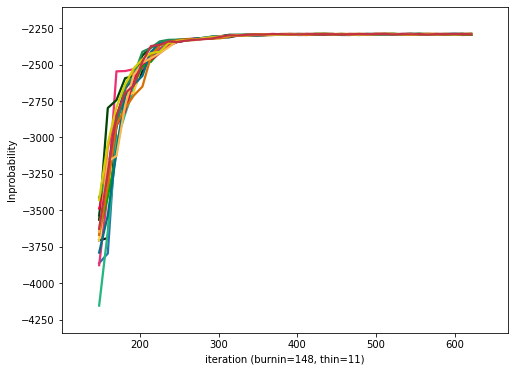

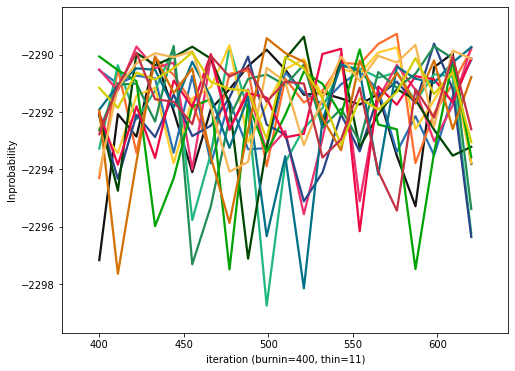

(<autofig.figure.Figure | 1 axes | 16 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [40]:
b.plot(solution='round_3', style='lnprobability', show=True)
b.plot(solution='round_3', style='lnprobability', burnin=400, show=True)

Corner plot:

(None, <Figure size 849.6x849.6 with 25 Axes>)

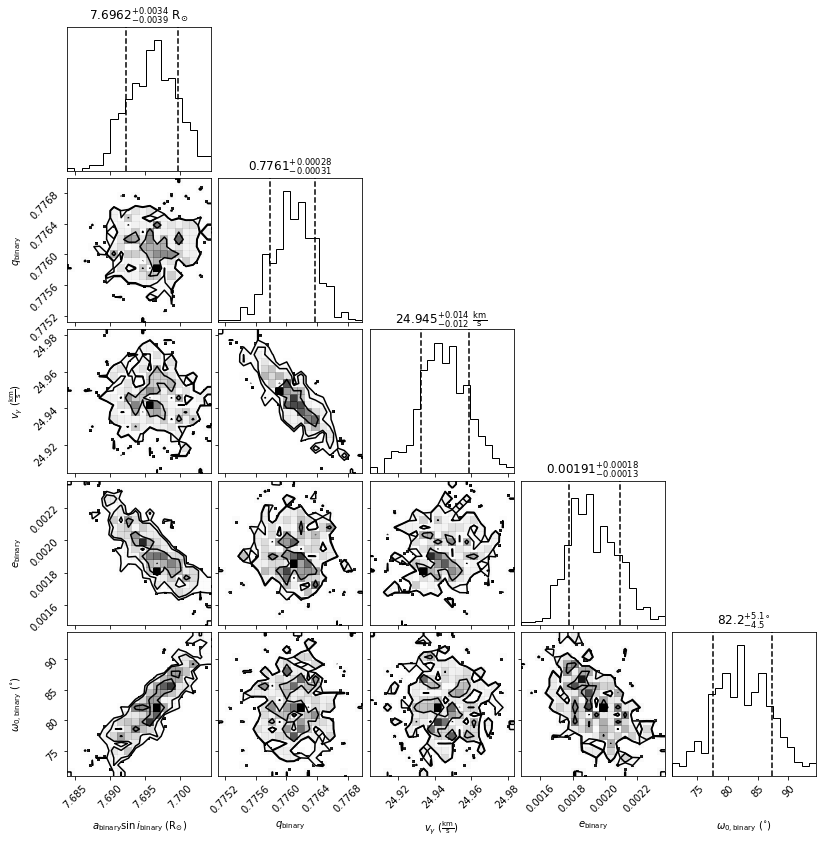

In [41]:
b.plot(solution='round_3', style='corner', burnin=400, show=True)

And finally the trace plot:

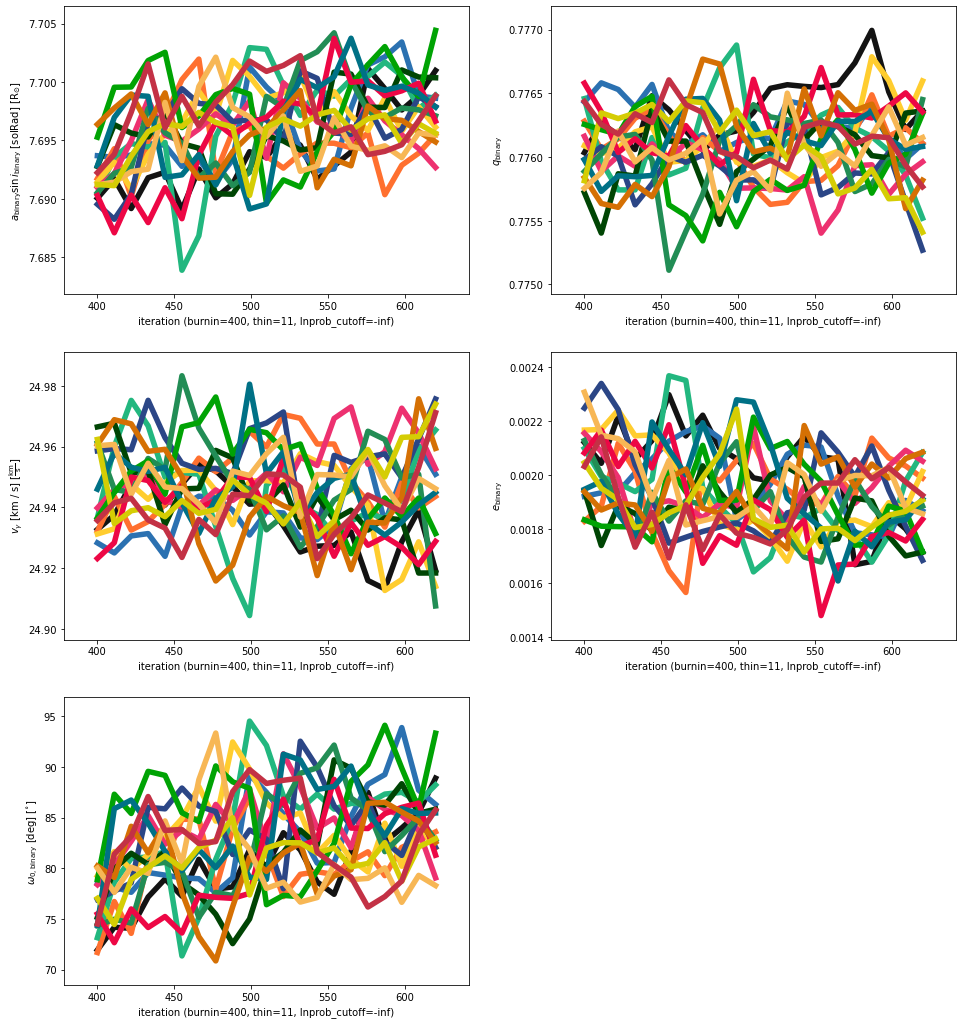

(<autofig.figure.Figure | 5 axes | 80 call(s)>,
 <Figure size 1152x1296 with 5 Axes>)

In [43]:
b.plot(solution='round_3', style='trace', burnin=400, show=True)

So how do we know when to stop? Is it converged yet?

In [41]:
def acf(ts, lags=0, submean=False, normed=True, p=0.05, bartlett=True):
    lags = len(ts) if lags==0 else lags
    c0 = np.sum((ts-ts.mean())**2)/len(ts) if normed else 1.0
    if submean:
        acf = np.array([np.sum((ts[k:]-ts[k:].mean())*(ts[:len(ts)-k]-ts[:len(ts)-k].mean()))/c0/len(ts) for k in range(lags)])
    else:
        acf = np.array([np.sum((ts[k:]-ts.mean())*(ts[:len(ts)-k]-ts.mean()))/c0/len(ts) for k in range(lags)])
    
    if bartlett:
        vacf = np.ones_like(acf)/len(ts)
        vacf[0] = 0
        vacf[1] = 1/len(ts)
        vacf[2:] *= 1+2*np.cumsum(acf[1:-1]**2)
        ci = norm.ppf(1-p/2) * np.sqrt(vacf)
#         ci = np.array(list(zip(acf-ci, acf+ci)))
    else:
        ci = np.sqrt(2)*erfinv(1-p)/np.sqrt(len(ts))
    
    return acf, ci

In [74]:
w1 = b['value@lnprobabilities@round_3'][b['value@burnin@round_3']:,0]

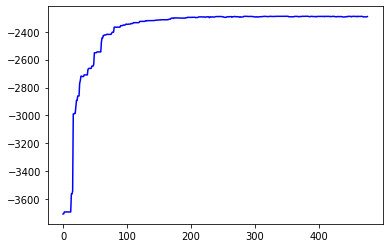

In [75]:
plt.plot(w1, 'b-')

In [76]:
acf_w1, acf_w1_ci = acf(w1, lags=65, normed=True)

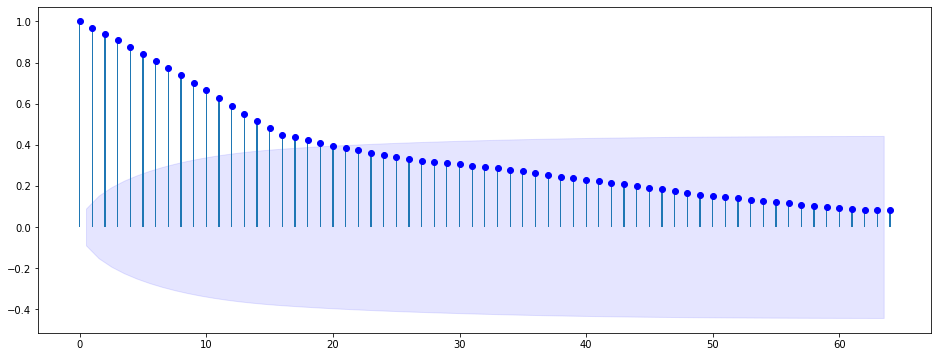

In [77]:
plt.figure(figsize=(16,6))
plt.bar(x=range(len(acf_w1)), height=acf_w1, width=0.1)
plt.plot(range(len(acf_w1)), acf_w1, 'bo')
plt.fill_between(np.arange(1, len(acf_w1_ci))-0.5, -acf_w1_ci[1:], acf_w1_ci[1:], color='b', alpha=0.1)
# xlim = plt.gca().get_xlim()
# plt.hlines([-acf_w1_ci, acf_w1_ci], xmin=xlim[0], xmax=xlim[1], color='g', linestyles='--')
# plt.xlim(xlim[0], xlim[1])

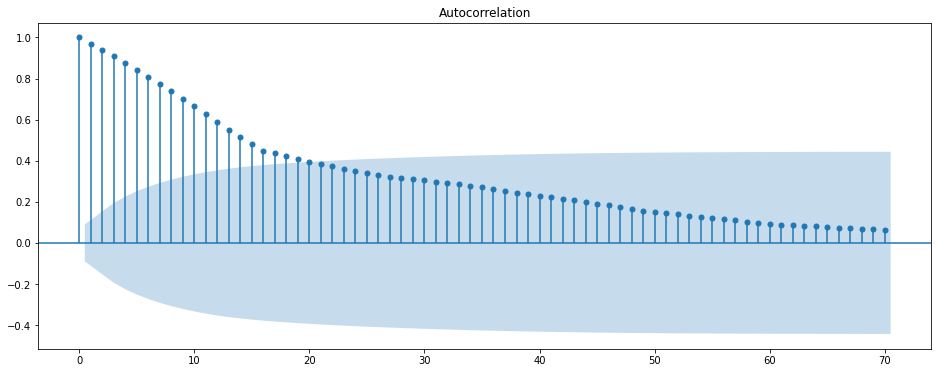

In [78]:
import statsmodels as sm
from statsmodels.graphics import tsaplots
plt.figure(figsize=(16,6))
ax = plt.gca()
_ = tsaplots.plot_acf(w1, lags=70, ax=ax)

In [79]:
acfs = [acf(b['value@lnprobabilities@round_3'][400:,k], lags=100, normed=True) for k in range(16)]

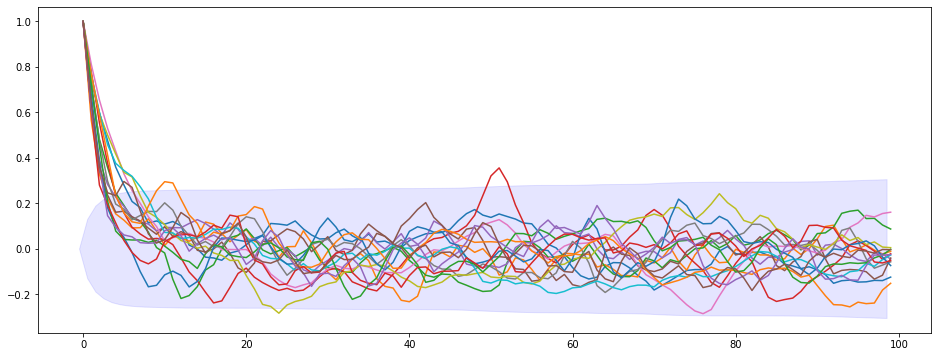

In [80]:
plt.figure(figsize=(16,6))
for k in range(16):
    plt.plot(acfs[k][0], '-')
plt.fill_between(np.arange(len(acfs[0][1]))-0.5, -acfs[0][1], acfs[0][1], color='b', alpha=0.1)
#     plt.axhline(-acfs[k][1], c='g', ls='--')
#     plt.axhline(acfs[k][1], c='g', ls='--')

Now let's try the parameters!

In [203]:
b['value@samples@round_3'].shape

(625, 16, 5)

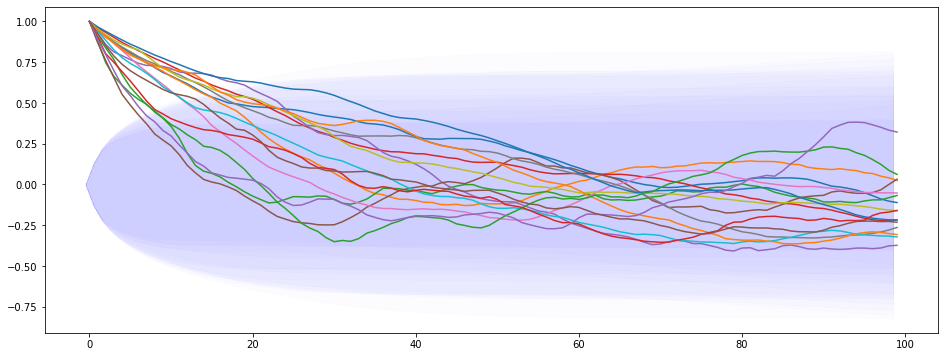

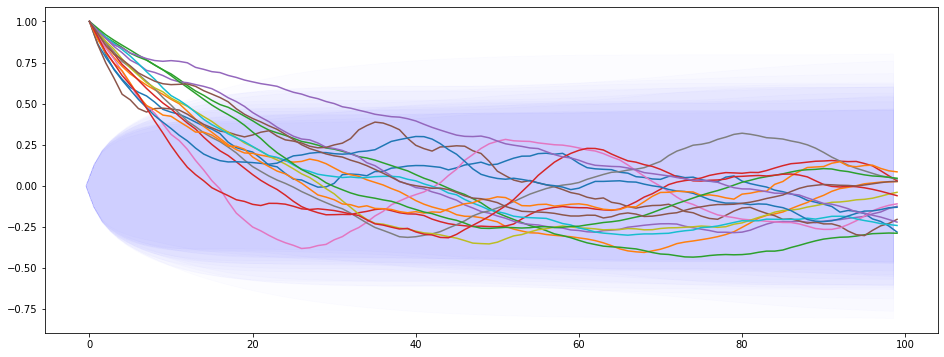

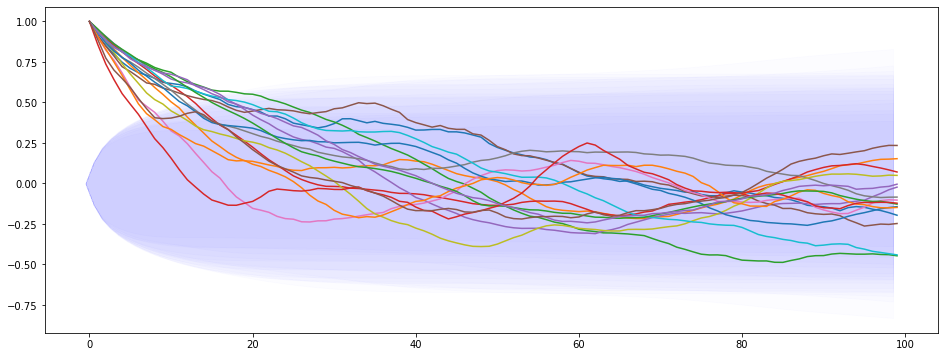

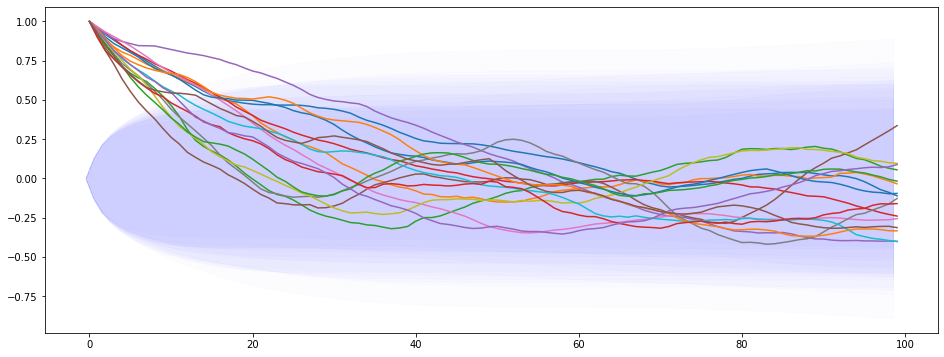

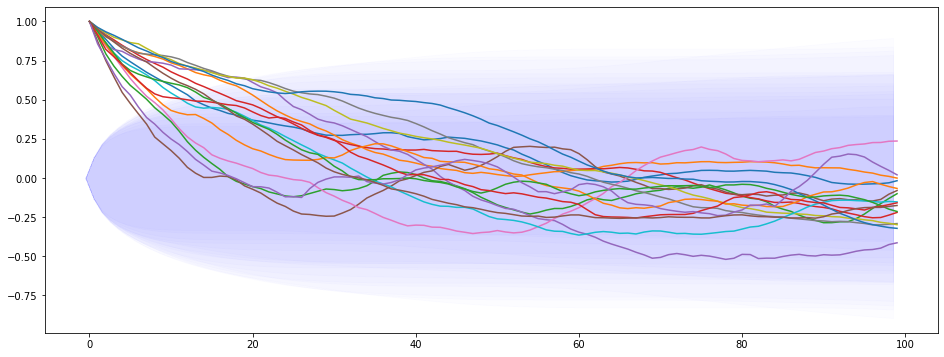

In [73]:
for i in range(5):
    acfs = [acf(b['value@samples@round_3'][400:,k,i], lags=100, normed=True) for k in range(16)]
    plt.figure(figsize=(16,6))
    for k in range(16):
        plt.plot(acfs[k][0], '-')
        plt.fill_between(np.arange(len(acfs[k][1]))-0.5, -acfs[k][1], acfs[k][1], color='b', alpha=0.01)

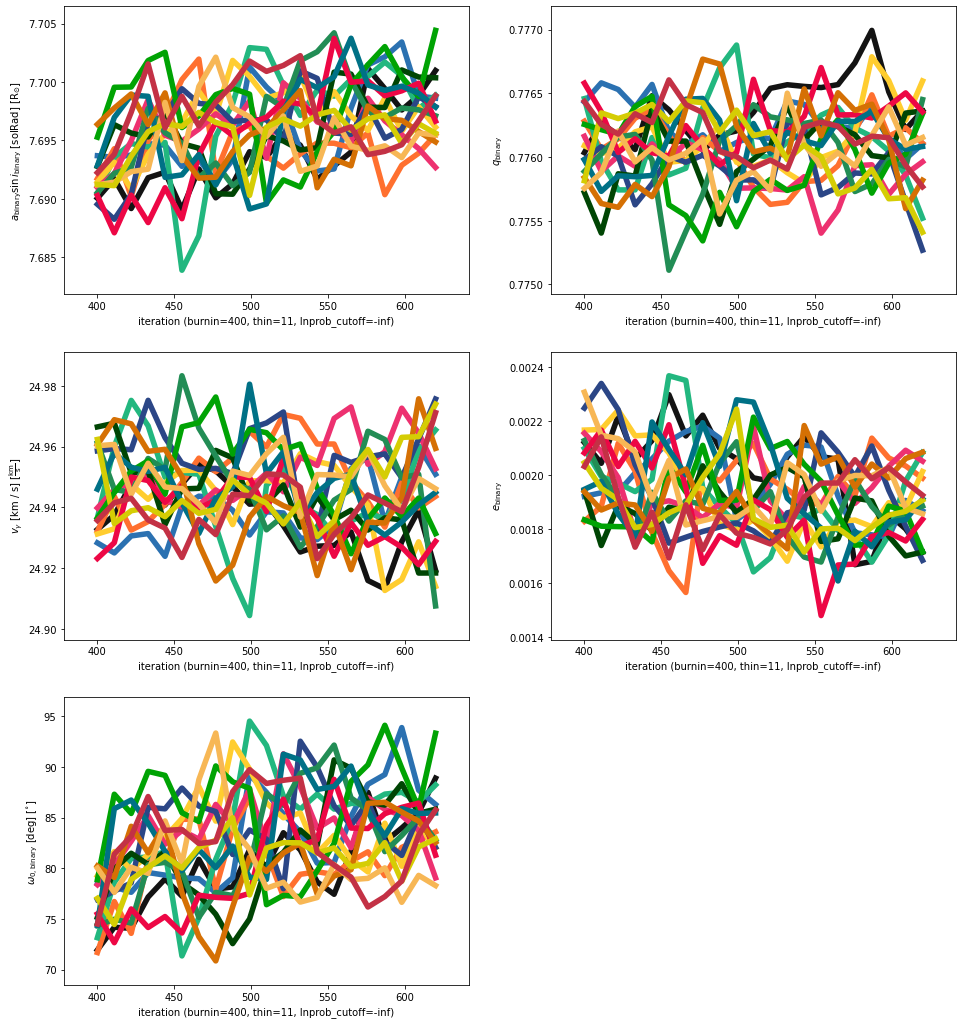

(<autofig.figure.Figure | 5 axes | 80 call(s)>,
 <Figure size 1152x1296 with 5 Axes>)

In [211]:
b.plot(solution='round_3', style='trace', burnin=400, show=True)

A-ha! So we're not converged yet! Let's do another round on terra!

In [212]:
b['continue_from@mcmc'] = 'round_3'

In [215]:
b.run_solver('mcmc', solution='round_4')

# crimpl: ssh terra "source ~/crimpl/exportpath.sh; conda -V"
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; conda info --envs"
# crimpl: ssh terra "ls -d ~/crimpl/crimpl-envs/*"
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; mkdir -p ~/crimpl"
# crimpl: scp crimpl_run_script.sh terra:~/crimpl/
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; cd ~/crimpl; chmod +x ./crimpl_run_script.sh; ./crimpl_run_script.sh"
# crimpl: ssh terra "ls -d ~/crimpl/crimpl-job-*"
# crimpl: ssh terra "pwd"
# crimpl: ssh terra "ls /home/users/andrej/crimpl/crimpl-job-2021.05.24-11.15.42/*"
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; conda -V"
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; conda info --envs"
# crimpl: ssh terra "ls -d ~/crimpl/crimpl-envs/*"
# crimpl: ssh terra "ls -d ~/crimpl/crimpl-job-2021.05.24-11.15.42/crimpl-envs/*"
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; mkdir -p /home/users/andrej/crimpl/crimpl-job-2021.05.24-11.15.42"
# crimpl: scp crimpl_submit

# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
#

# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
#

# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
#

# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
#

# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
#

# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
#

# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
#

# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
#

# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
#

# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
#

# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
#

# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
#

# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
#

# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
# crimpl: ssh terra "squeue -j 1529"
#

<ParameterSet: 21 parameters | qualifiers: fitted_units, burnin, failed_samples, fitted_uniqueids, adopt_values, lnprobabilities, thin, samples, adopt_distributions, progress, autocorr_times, comments, nwalkers, niters, wrap_central_values, distributions_bins, distributions_convert, adopt_parameters, lnprob_cutoff, acceptance_fractions, fitted_twigs>

In [15]:
b.save('./data/synthetic/after_terra_2.bundle')

'./data/synthetic/after_terra_2.bundle'

(None, <Figure size 849.6x849.6 with 25 Axes>)

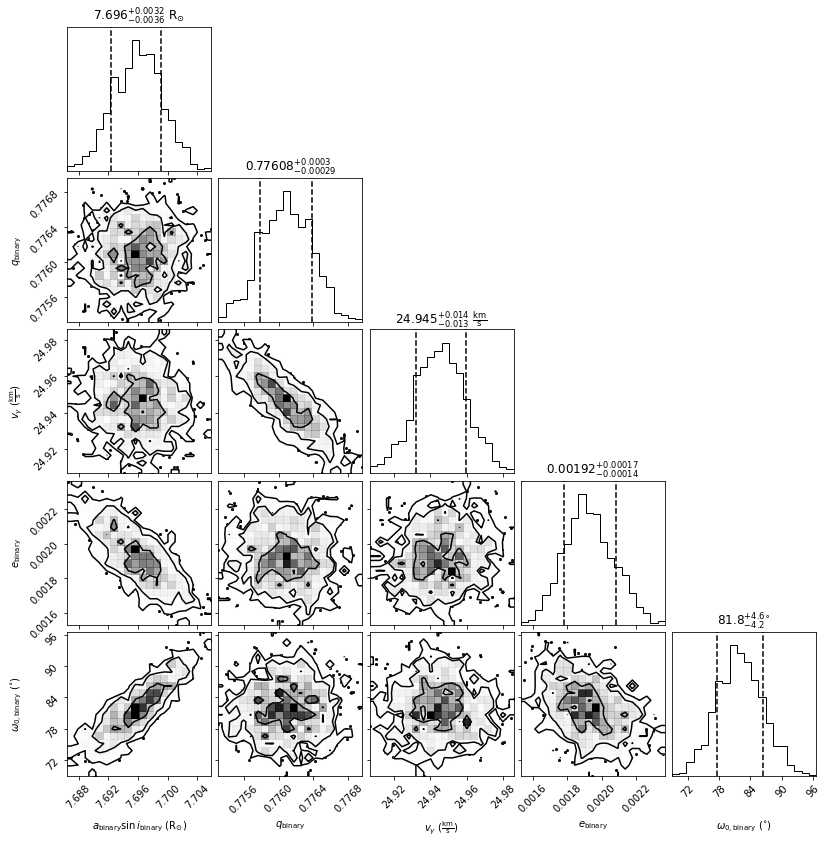

In [218]:
b.plot(solution='round_4', style='corner', burnin=400, show=True)

In [219]:
acfs = [acf(b['value@lnprobabilities@round_4'][400:,k], lags=100, normed=True) for k in range(16)]

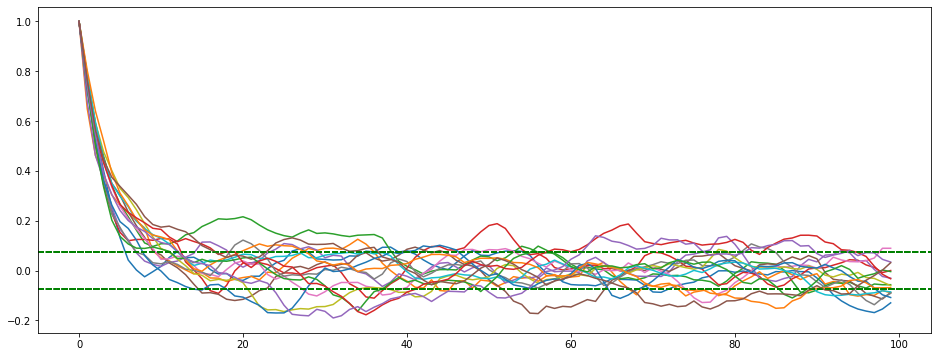

In [220]:
plt.figure(figsize=(16,6))
for k in range(16):
    plt.plot(acfs[k][0], '-')
    plt.axhline(-acfs[k][1], c='g', ls='--')
    plt.axhline(acfs[k][1], c='g', ls='--')

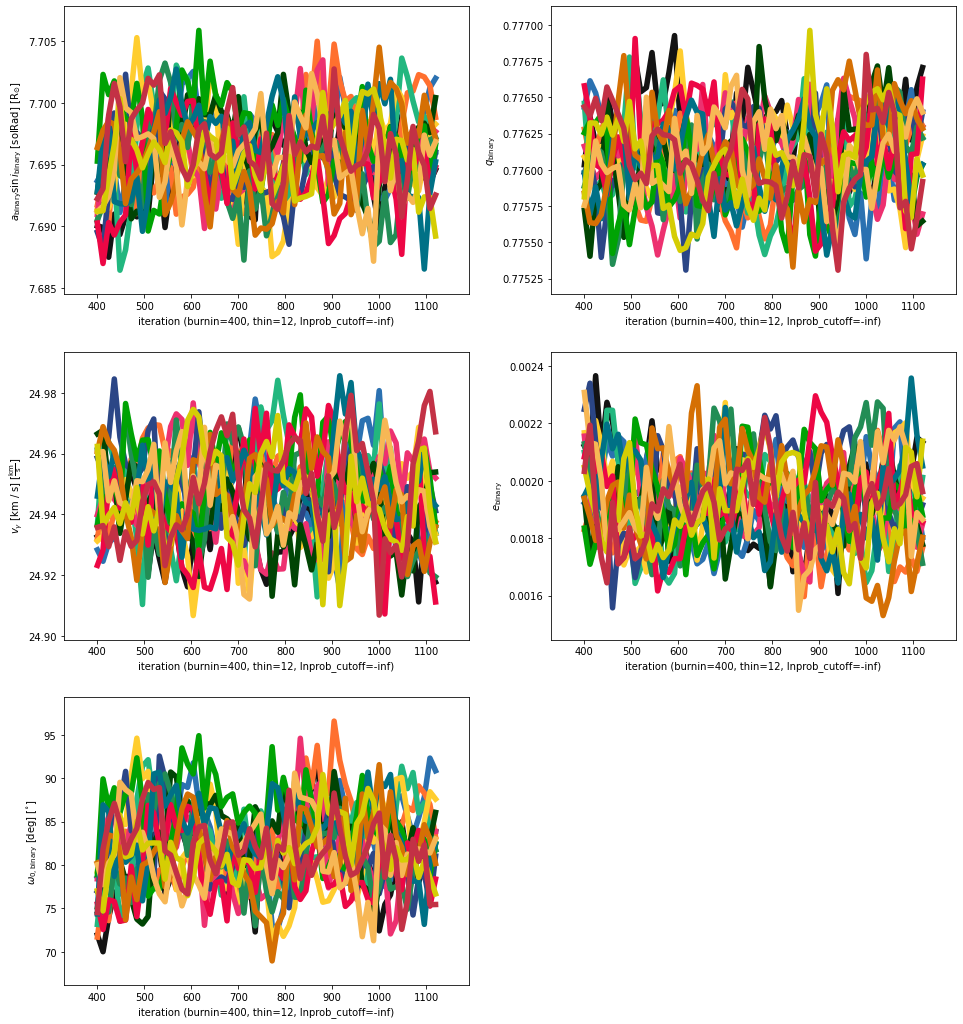

(<autofig.figure.Figure | 5 axes | 80 call(s)>,
 <Figure size 1152x1296 with 5 Axes>)

In [222]:
b.plot(solution='round_4', style='trace', burnin=400, show=True)

In [2]:
b = phoebe.load('./data/synthetic/after_terra_2.bundle')

/usr/local/lib/python3.9/dist-packages/phoebe/parameters/parameters.py:10312: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self._value = np.array(value)


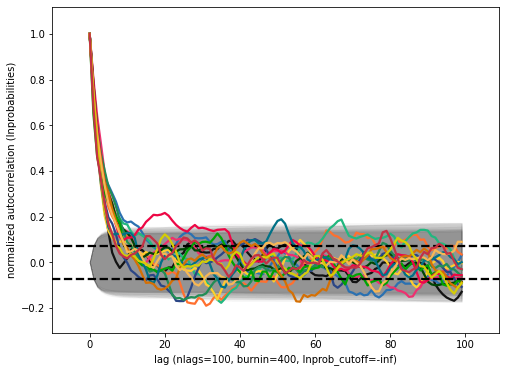

(<autofig.figure.Figure | 1 axes | 34 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [3]:
b.plot(solution='round_4', style='acf_lnprobabilities', nlags=100, burnin=400, show=True)

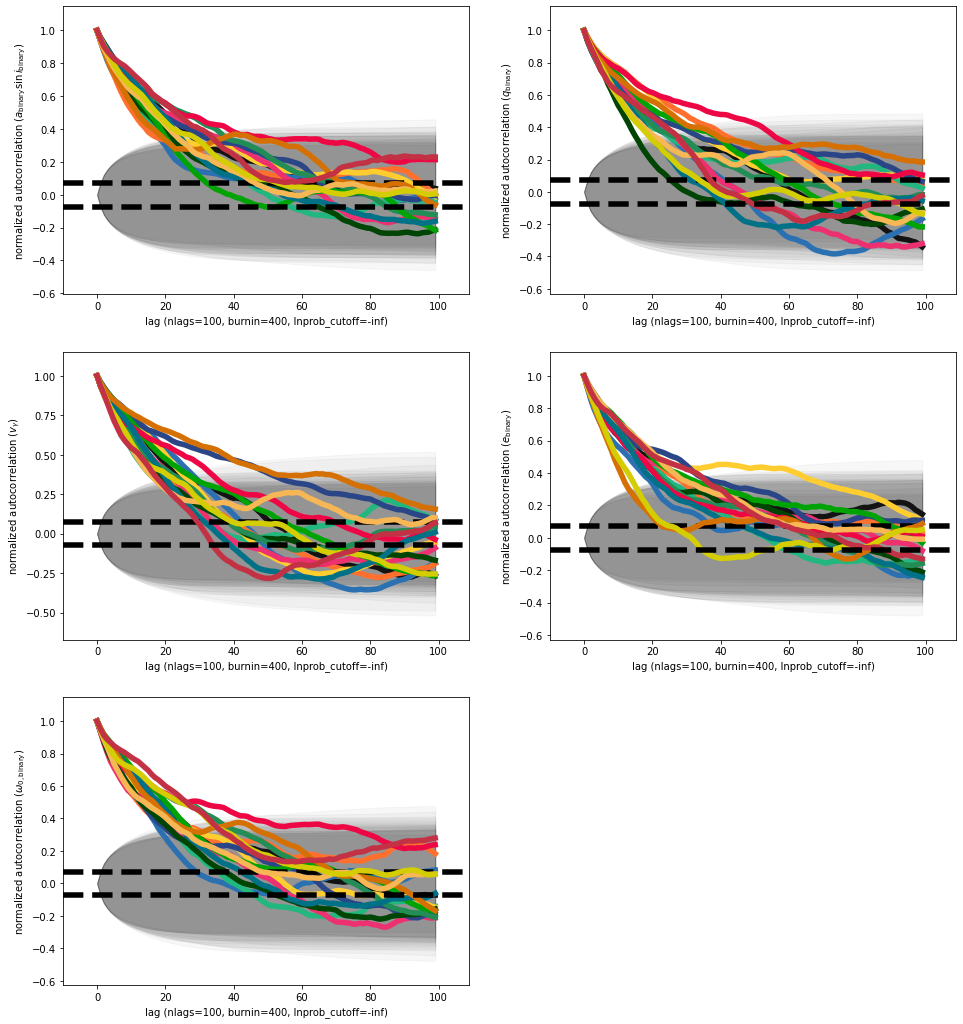

(<autofig.figure.Figure | 5 axes | 170 call(s)>,
 <Figure size 1152x1296 with 5 Axes>)

In [4]:
b.plot(solution='round_4', style='acf', nlags=100, burnin=400, show=True)

In [3]:
print(b['terra'])

ParameterSet: 12 parameters
R   detached_job@round_3@solution: unknown
R   detached_job@round_4@solution: unknown
         crimpl_name@terra@server: terra
           use_conda@terra@server: True
           conda_env@terra@server: workshop
         isolate_env@terra@server: False
              nprocs@terra@server: 96
             use_mpi@terra@server: True
        install_deps@terra@server: True
      slurm_job_name@terra@server: 
            walltime@terra@server: 48.0 h
           mail_user@terra@server: 


In [3]:
b['continue_from@mcmc'] = 'round_4'
b.run_solver('mcmc',
             solution='final_round',
             continue_from='round_4',
             niters=1500,
             use_server='terra',
             progress_every_niters=100, 
             nprocs=384,
             walltime=(48,'hr'),
             detach=True)

# crimpl: ssh terra "mkdir -p ~/crimpl"
# crimpl: scp exportpath.sh terra:~/crimpl/
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; conda -V"
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; conda info --envs"
# crimpl: ssh terra "ls -d ~/crimpl/crimpl-envs/*"
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; mkdir -p ~/crimpl"
# crimpl: scp crimpl_run_script.sh terra:~/crimpl/
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; cd ~/crimpl; chmod +x ./crimpl_run_script.sh; ./crimpl_run_script.sh"
# crimpl: ssh terra "ls -d ~/crimpl/crimpl-job-*"
# crimpl: ssh terra "pwd"
# crimpl: ssh terra "ls /home/users/andrej/crimpl/crimpl-job-2021.05.29-22.36.01/*"
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; conda -V"
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; conda info --envs"
# crimpl: ssh terra "ls -d ~/crimpl/crimpl-envs/*"
# crimpl: ssh terra "ls -d ~/crimpl/crimpl-job-2021.05.29-22.36.01/crimpl-envs/*"
# crimpl: ssh terra "source ~/crimpl/exportpath.sh; mkdir -p /

<Parameter: detached_job=unknown | keys: description, value, job_name, uniqueid, readonly, advanced, latexfmt>

In [4]:
print(b.get_solution('final_round'))

ParameterSet: 2 parameters
R  detached_job@final_round@so...: unknown
    comments@final_round@solution: 


In [6]:
print(b['continue_from@mcmc'])

Parameter: continue_from@mcmc@solver
                       Qualifier: continue_from
                     Description: continue the MCMC run from an existing emcee solution.  Chains will be appended to existing chains (so it is safe to overwrite the existing solution).  If None, will start a new run using init_from.
                           Value: round_3
                         Choices: None, round_1, round_2, round_3, round_4
                  Constrained by: 
                      Constrains: None
                      Related to: None



In [5]:
b.get_job_status(solution='final_round')

# crimpl: ssh terra "ls -d ~/crimpl/crimpl-job-*"
# crimpl: ssh terra "pwd"
# crimpl: ssh terra "cat /home/users/andrej/crimpl/crimpl-job-2021.05.29-22.36.01/crimpl_slurm_id"
# crimpl: ssh terra "squeue -j 1549"
# crimpl: ssh terra "cat /home/users/andrej/crimpl/crimpl-job-2021.05.29-22.36.01/crimpl-job.status"


'complete'

In [6]:
b.load_job_progress(solution='final_round')

# crimpl: ssh terra "ls /home/users/andrej/crimpl/crimpl-job-2021.05.29-22.36.01/*"
# crimpl: ssh terra "ls /home/users/andrej/crimpl/crimpl-job-2021.05.29-22.36.01/*"
# crimpl: scp terra:/home/users/andrej/crimpl/crimpl-job-2021.05.29-22.36.01/{_ZGrBPVywtjdesUFWXISmSvSbPKMQcd.out,_ZGrBPVywtjdesUFWXISmSvSbPKMQcd.out.progress} ./


<ParameterSet: 22 parameters | qualifiers: nwalkers, progress, thin, fitted_twigs, fitted_units, wrap_central_values, adopt_distributions, comments, autocorr_times, niters, adopt_values, distributions_bins, adopt_parameters, fitted_uniqueids, distributions_convert, nlags, burnin, acceptance_fractions, lnprobabilities, failed_samples, samples, lnprob_cutoff>

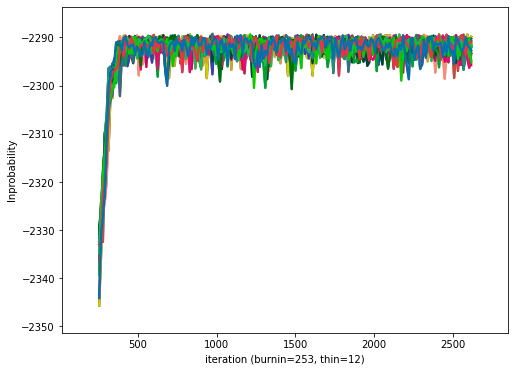

(<autofig.figure.Figure | 1 axes | 32 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [9]:
b.plot(solution='final_round', style='lnprobabilities', show=True)

(None, <Figure size 849.6x849.6 with 25 Axes>)

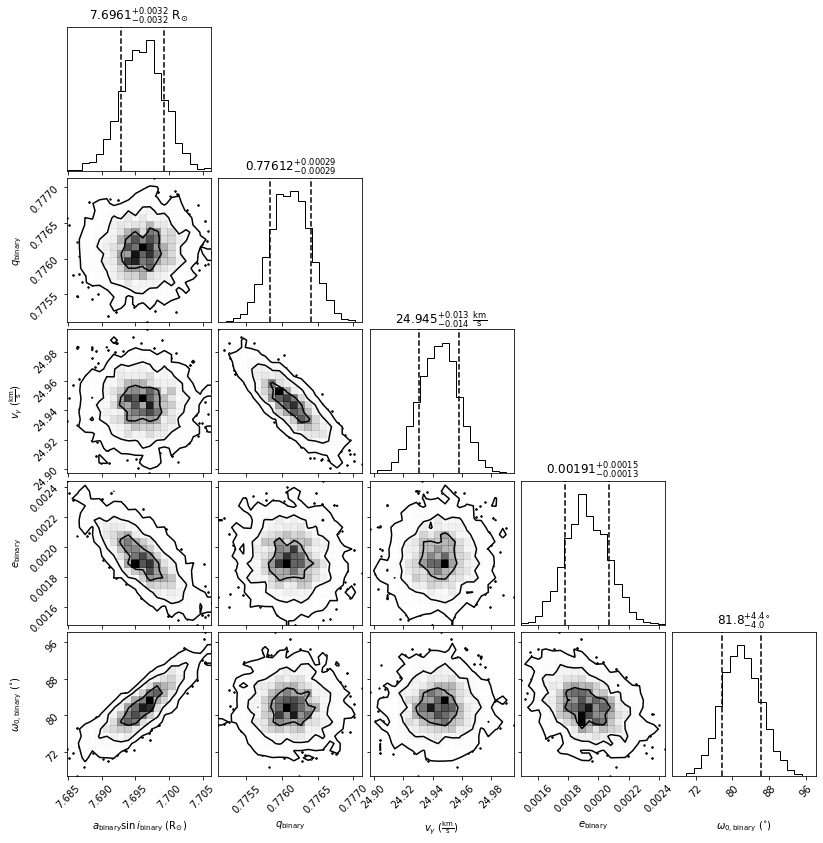

In [10]:
b.plot(solution='final_round', style='corner', burnin=500, show=True)

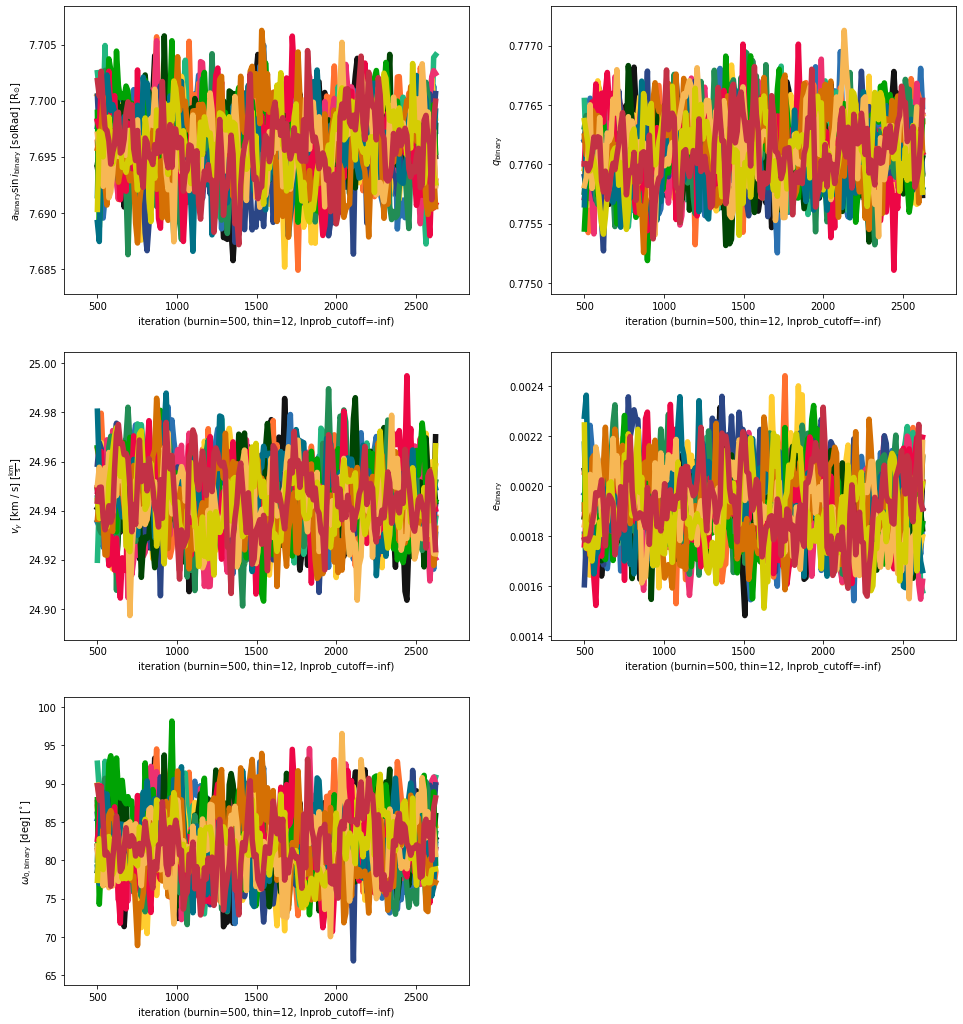

(<autofig.figure.Figure | 5 axes | 80 call(s)>,
 <Figure size 1152x1296 with 5 Axes>)

In [11]:
b.plot(solution='final_round', style='trace', burnin=500, show=True)

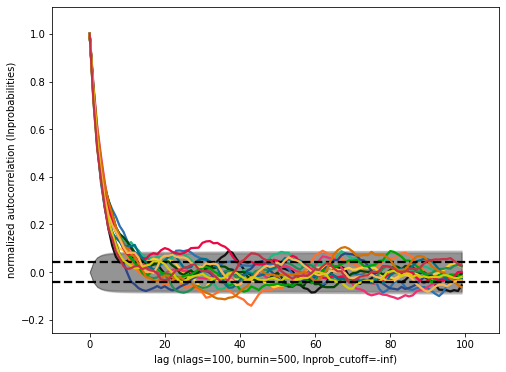

(<autofig.figure.Figure | 1 axes | 34 call(s)>,
 <Figure size 576x432 with 1 Axes>)

In [13]:
b.plot(solution='final_round', style='acf_lnprobabilities', nlags=100, burnin=500, show=True)

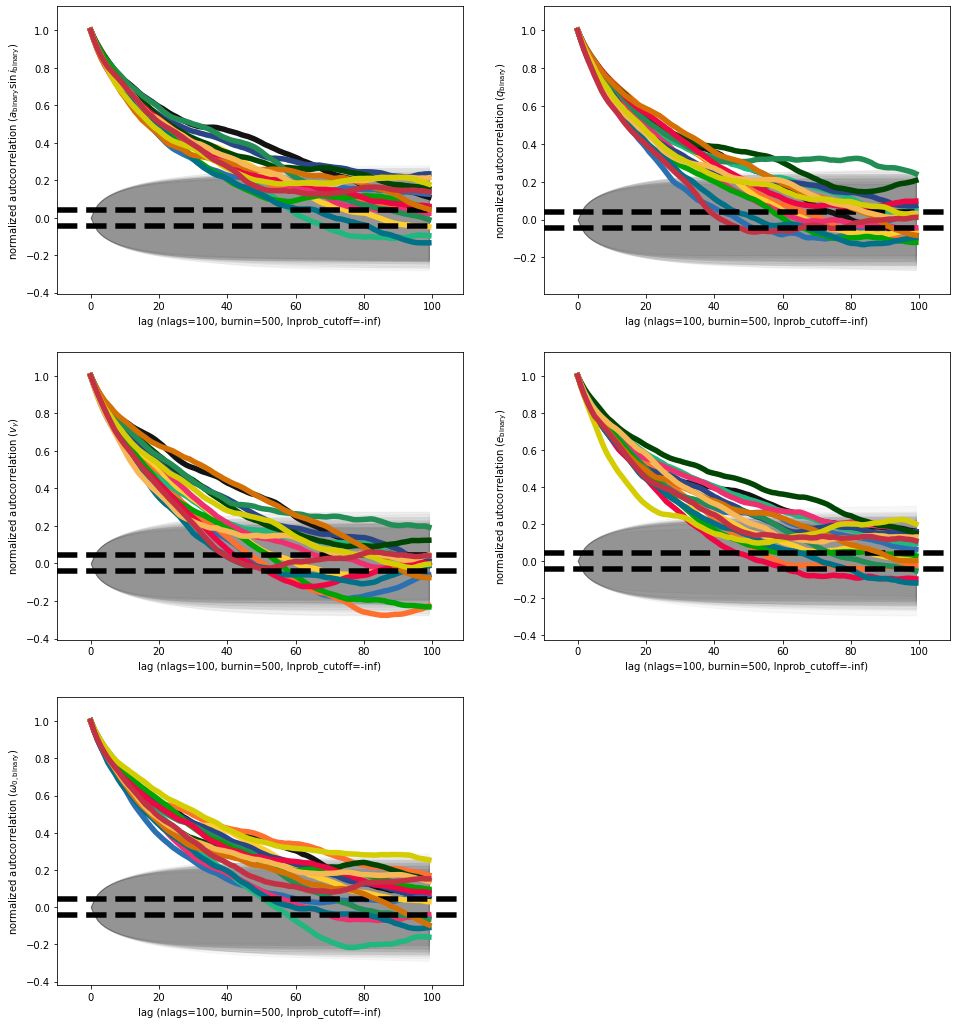

(<autofig.figure.Figure | 5 axes | 170 call(s)>,
 <Figure size 1152x1296 with 5 Axes>)

In [16]:
b.plot(solution='final_round', style='acf', nlags=100, burnin=500, show=True)

In [18]:
b.save('./data/synthetic/after_final_round.bundle')

'./data/synthetic/after_final_round.bundle'